In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # This can be either JAX, tensorflow, or torch. (tensorflow by default)

In [2]:
import keras
from keras import ops
from keras import layers
from keras.models import Model
print(f"Keras backend: {keras.backend.backend()}")

import pennylane as qml
import jax.numpy as jnp
import numpy as  np
import matplotlib.pyplot as plt
import jax

from sklearn.datasets import make_moons

Keras backend: jax


## Get Dataset

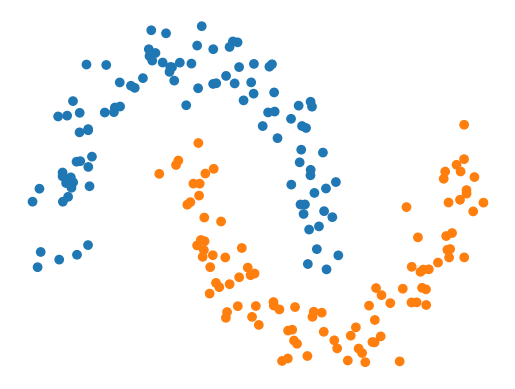

In [7]:
X, y = make_moons(n_samples=200, noise=0.1)
y_ = ops.unstack(y,1)
y_hot = ops.one_hot(y_,2)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

## Define QNode
Our next step is to define the QNode that we want to interface with keras 3. Any combination of device, operations and measurements that is valid in PennyLane can be used to compose the QNode. However, the QNode arguments must satisfy additional conditions including having an argument called inputs. All other arguments must be arrays or tensors and are treated as trainable weights in the model. We fix a two-qubit QNode using the default.qubit simulator and operations from the templates module.

In [8]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

## Interfacing with Keras 3

In [9]:
from pennylane_keras_layer import KerasCircuitLayer

In [10]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

# Create the layer
qlayer = KerasCircuitLayer(qnode, weight_shapes, output_dim=n_qubits)

## Creating the Hybrid Model

In [11]:
model = keras.Sequential([
    keras.layers.Dense(2, input_shape=(2,)),
    qlayer,
    keras.layers.Dense(2),
    keras.layers.Softmax()
])

model.summary()

/home/common/miniconda3/envs/QMLJax/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ keras_circuit_layer             │ (None, 2)              │            12 │
│ (KerasCircuitLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

#### Plotting the quantum circuit

In [13]:
model.layers[1].draw_qnode()

AttributeError: 'KerasCircuitLayer' object has no attribute 'draw_qnode'